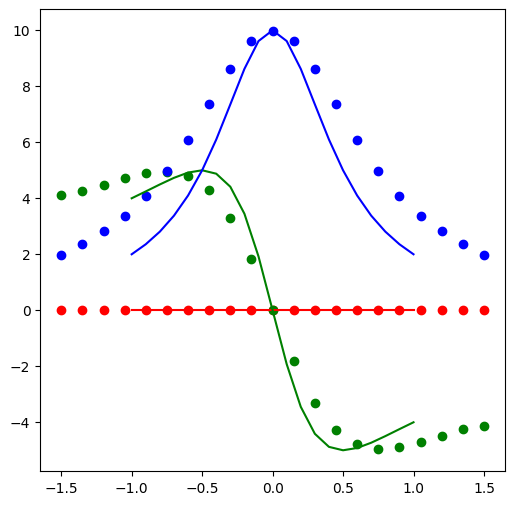

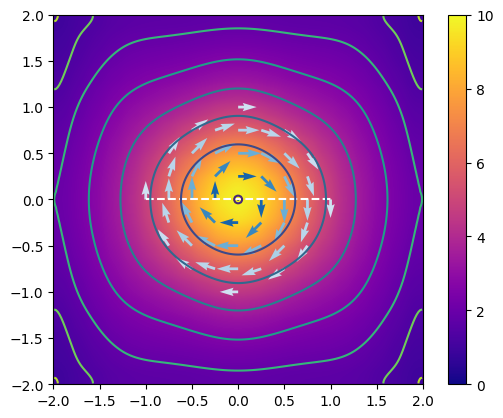

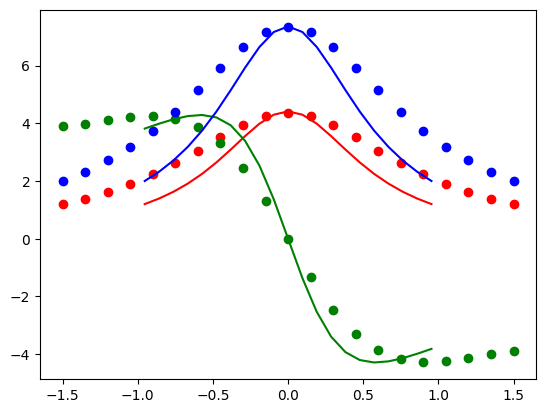

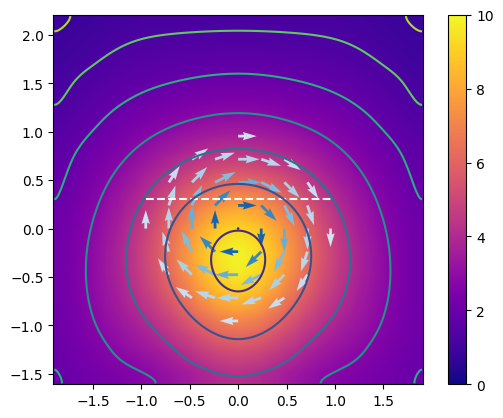

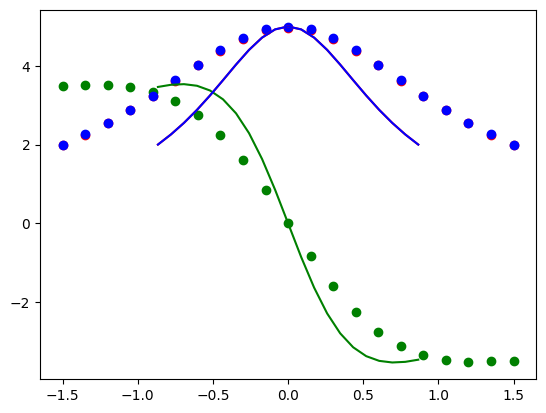

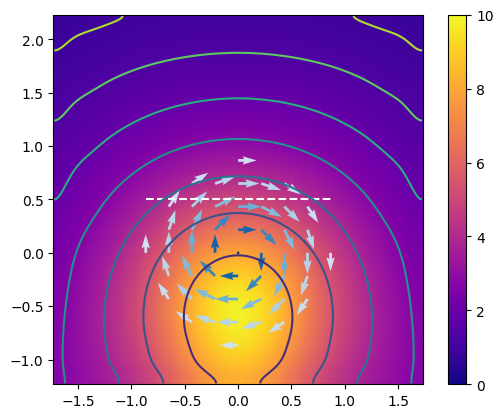

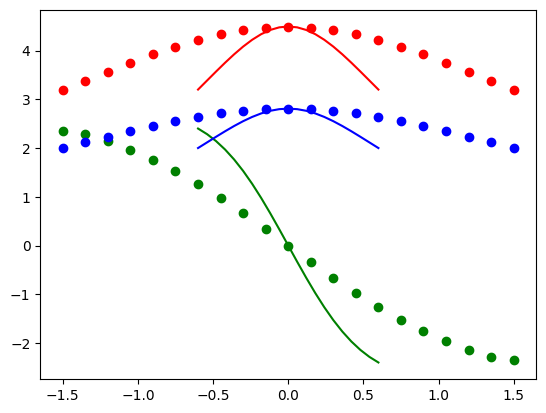

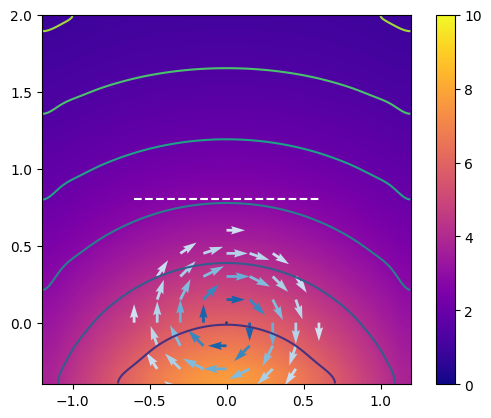

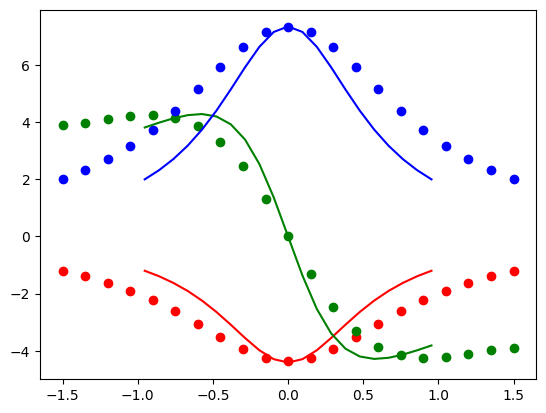

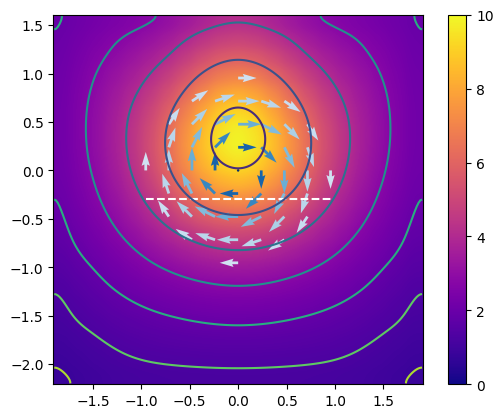

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import matplotlib.cm
from pymfr.reconstruct import reconstruct_map
import scipy.ndimage

def gold_hoyle(x, y, B0, T0):
    r = np.sqrt(x ** 2 + y ** 2)
    Bz = B0 / (1 + T0 ** 2 * r ** 2)
    Bphi = B0 * T0 * r / (1 + T0 ** 2 * r ** 2)
    angle = np.arctan2(y, x)
    return -np.sin(angle) * Bphi, np.cos(angle) * Bphi, Bz


def spacecraft_path(y0, n):
    # from x^2 + y0^2 = r0^2
    x0 = np.sqrt(radius ** 2 - y0 ** 2)
    x = np.linspace(-x0, x0, n)
    y = np.linspace(y0, y0, n)
    return x, y


plt.figure(figsize=(6, 6))
radius = 1
B0 = 10
T0 = -2
xx, yy = np.meshgrid(np.linspace(-radius, radius, 9), np.linspace(-radius, radius, 9))
xx = xx.flatten()
yy = yy.flatten()
distance = np.sqrt(xx ** 2 + yy ** 2)
xx = xx[distance <= radius]
yy = yy[distance <= radius]

Bx_map, By_map, Bz_map = gold_hoyle(xx.flatten(), yy.flatten(), B0=B0, T0=T0)

for impact_parameter in [0, 0.3, 0.5, .8, -0.3]:
    resolution = 21
    pad = 5
    N = 21
    x, y = spacecraft_path(impact_parameter, N)
    Bx, By, Bz = gold_hoyle(x, y, B0=B0, T0=T0)

    width = x[-1] - x[0]

    input_B = np.column_stack([Bx, By, Bz])
    # input_B = np.pad(input_B, [(N // 2, N // 2), (0, 0)], mode="constant")
    # input_B[:, 2] = np.maximum(input_B[:, 2], np.min(Bz))
    cross_section = reconstruct_map(input_B,
                                    gas_pressure_observed=np.zeros_like(input_B[:, 0]),
                                    poly_order=3, 
                                    sample_spacing=1,
                                    aspect_ratio=1,
                                    resolution=resolution,
                                    pad=pad)

    plt.plot(x, Bx, color="red")
    plt.scatter(np.linspace(-1.5, 1.5, resolution), cross_section.magnetic_field_x[resolution // 2, :], color="red")
    plt.plot(x, By, color="green")
    plt.scatter(np.linspace(-1.5, 1.5, resolution), cross_section.magnetic_field_y[resolution // 2, :], color="green")
    plt.plot(x, Bz, color="blue")
    plt.scatter(np.linspace(-1.5, 1.5, resolution), cross_section.magnetic_field_z[resolution // 2, :], color="blue")
    plt.show()

    extent = (x[0] - width / 2, x[-1] + width / 2, -width/2 + impact_parameter - width/2, width/2 + impact_parameter + width/2)
    plt.imshow(cross_section.magnetic_field_z, vmin=0, vmax=10, cmap="plasma", extent=extent, origin="lower", interpolation="gaussian")
    plt.colorbar()

    plt.plot([-width / 2, width / 2], [impact_parameter, impact_parameter], color="white", ls="--")

    plt.contour(scipy.ndimage.zoom(cross_section.magnetic_potential, 10), origin="lower", extent=extent)

    plt.xlim(extent[0], extent[1])
    plt.ylim(extent[2], extent[3])


    plt.quiver((xx.flatten()) * (width / 2), (yy.flatten()) * (width / 2), Bx_map, By_map, color=matplotlib.cm.Blues(Bz_map / Bz_map.max()))
    plt.show()